## Import Dependency

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

## Load Dataset

In [4]:
file =  '../Dataset/insurance.csv'

In [5]:
df = pd.read_csv(file)

In [6]:
# Sample Data
print(df.head())

# Rows and Columns Count
print ("Rows and Column")
print(df.shape)

# Get basic statistics for numerical columns
print(df.describe())

# Check column data types
print(df.dtypes)

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
Rows and Column
(1338, 7)
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010
age           int64
sex          object
bmi         float64

## Data Pre Processing

## Handling Duplicate Data

In [9]:
# Remove the duplicate row
df = df.drop_duplicates()

# Verify that the duplicate is removed
print(f"After removing duplicates, the new count of rows: {df.shape[0]}")

After removing duplicates, the new count of rows: 1337


## Encoding Categorical Data

In [11]:
# Encode Categorical data to numeric

# Perform One-Hot Encoding for 'sex', 'smoker', and 'region'
df = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

## Handling Skewed data

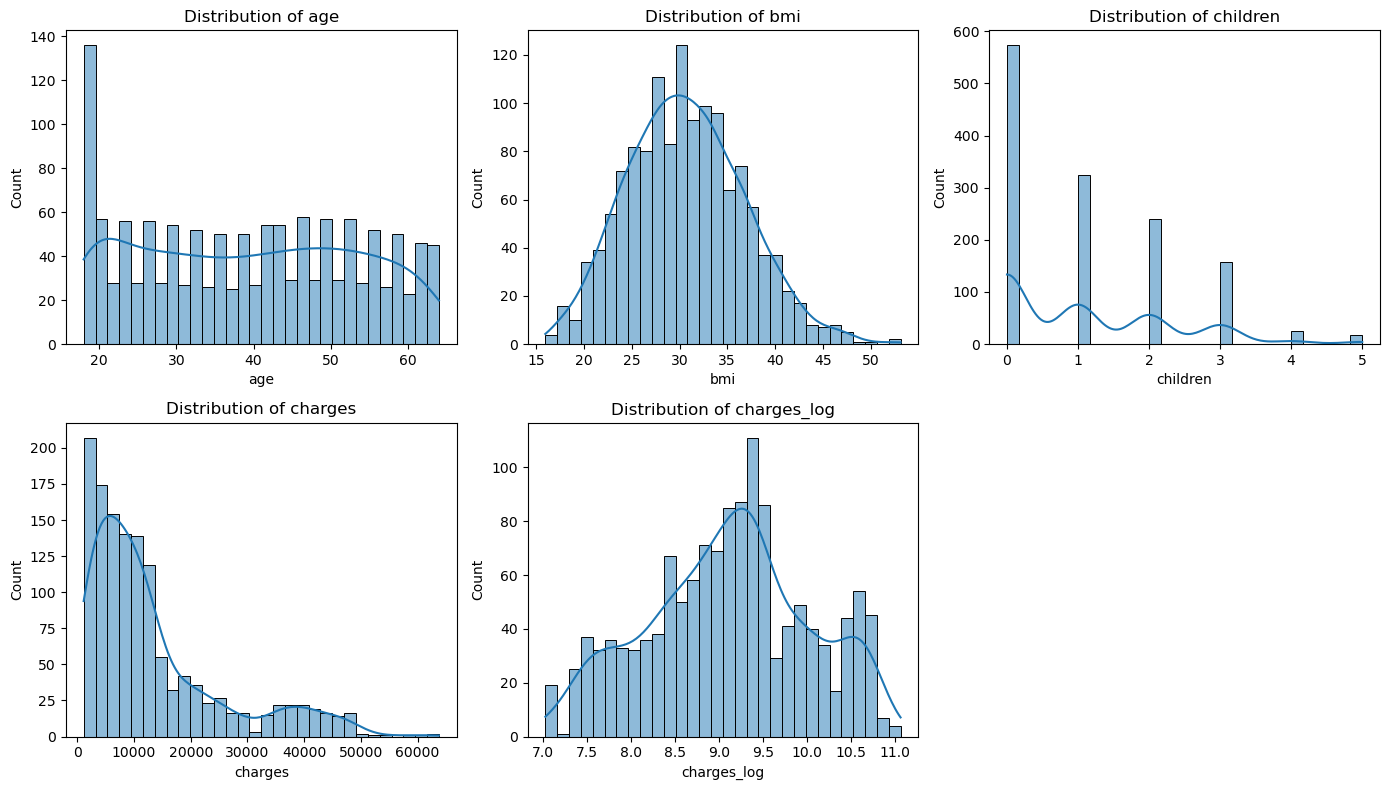

In [13]:
# Apply log transformation to 'charges' to handle the positive skew
df['charges_log'] = np.log1p(df['charges'])  # log1p is log(x + 1)

# Update numerical columns to include 'charges_log'
numerical_cols = ['age', 'bmi', 'children', 'charges', 'charges_log']

# Create a figure and axes for subplots
plt.figure(figsize=(14, 8))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)  # 2 rows, 3 columns (for 5 variables)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

## Handling Imbalanced data

In [15]:
# Split the dataset into training and testing sets
X = df.drop('smoker_yes', axis=1)
y = df['smoker_yes']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit and resample the training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Combine resampled features and target into one DataFrame
df = pd.concat([X_resampled, y_resampled.rename('smoker_yes')], axis=1)

# Check the new class balance
print("Resampled dataset created successfully!")
print(df['smoker_yes'].value_counts())
print("\nUpdated DataFrame shape:", df.shape)
df.head()

Resampled dataset created successfully!
smoker_yes
False    855
True     855
Name: count, dtype: int64

Updated DataFrame shape: (1710, 10)


,age,bmi,children,charges,sex_male,region_northwest,region_southeast,region_southwest,charges_log,smoker_yes
0,23,24.510,0,2396.09590,True,False,False,False,7.782013,False
1,21,25.745,2,3279.86855,True,False,False,False,8.095863,False
2,52,37.525,2,33471.97189,False,True,False,False,10.418494,False
3,63,41.470,0,13405.39030,True,False,True,False,9.503487,False
4,47,26.600,2,9715.84100,False,False,False,False,9.181616,False


## Feature Selection

Feature Importances

            Feature  Importance
7        smoker_yes    0.627295
1               bmi    0.267080
0               age    0.083221
2          children    0.010592
4  region_northwest    0.003304
5  region_southeast    0.003144
3          sex_male    0.003138
6  region_southwest    0.002227


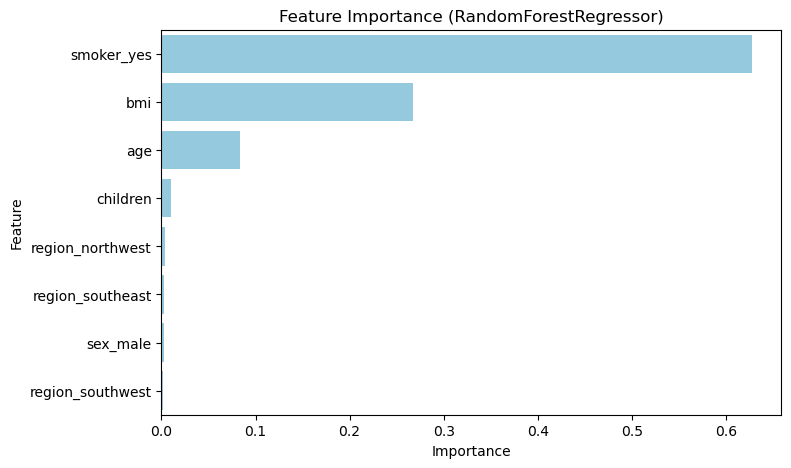

In [41]:

# Define features (X) and target (y) from the current df
X = df.drop(['charges', 'charges_log'], axis=1, errors='ignore')
y = df['charges']

# Train the RandomForest model
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

# Get feature importances
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display results
print("Feature Importances\n")
print(importances)

# Visualize feature importance
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=importances, color='skyblue')
plt.title("Feature Importance (RandomForestRegressor)")
plt.show()

In [45]:
# Selected features
selected_features = ['age', 'bmi', 'smoker_yes']

# Create new DataFrame with features + target
df_processed = df[selected_features + ['charges', 'charges_log']]

# Check
print(df_processed.head())
print("Shape:", df_processed.shape)


   age     bmi  smoker_yes      charges  charges_log
0   23  24.510       False   2396.09590     7.782013
1   21  25.745       False   3279.86855     8.095863
2   52  37.525       False  33471.97189    10.418494
3   63  41.470       False  13405.39030     9.503487
4   47  26.600       False   9715.84100     9.181616
Shape: (1710, 5)


## Export Processed Dataset